In [1]:
#Import all the required libraries
from transformFred import getFredData
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as smodels
from sklearn.externals import joblib
import functools
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import pprint
from fbprophet import Prophet


/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
#Initiate Fred Object
FredData = getFredData() #this is a class defined in transformFred.py



ac = FredData.available_codes().reset_index().set_index('Code')

#create a dictionary of macroecon variables
dict_macrovars = dict()

#initialize the start and end dates for the macroeconomic variables data pull
#list_macrovars = ['HPI', 'GDP', 'MORTGAGE30US', 'UE','GS10'] #names of macroeconomic variables (MEVs)
list_macrovars = ['HPI', 'MORTGAGE30US', 'UE','GS10'] #names of macroeconomic variables (MEVs) -take out GDP
startDate = '1990-12-25'
endDate   = '2018-12-31'

In [3]:
#Define Stationarity Tests and Diagnostics - p-Value etc.
def stationarity_test(series_data,sig_level,display):

    kpss_stats = kpss(series_data)
    adf_stats = adfuller(series_data)

    significance_threshold_kpss = kpss_stats[3][sig_level]
    significance_threshold_adf  = adf_stats[4][sig_level]
    tstat_kpss = np.abs(kpss_stats[0])
    tstat_adf = np.abs(adf_stats[0])

    kpss_stationarity = 'Stationary'
    adf_stationarity = 'Non-Stationary'
    if tstat_kpss > significance_threshold_kpss:
        kpss_stationarity = 'Non-Stationary'
    if tstat_adf > significance_threshold_adf:
        adf_stationarity = 'Stationary'
    #1 = Stationary
    if(display == True):
        print("Var:",var,"KPSS: ",kpss_stationarity,"ADF",adf_stationarity,tstat_kpss,tstat_adf)
    
    return kpss_stats, adf_stats

Explore the frequency of the macro variables

In [38]:
kpss_stats = kpss(FredData.fetch_data('UE').values[:,1])
sig = kpss_stats[3]['5%']
t = kpss_stats[0]
print(t)
print(sig)
print('stationary') if t<sig else print('non-stationary')

UNRATE
0.5131965231160912
0.463
non-stationary


In [4]:
for var in list_macrovars:
    macro_df = FredData.fetch_data(var)
    macro_df =  macro_df[(macro_df.Date >= startDate) & (macro_df.Date<=endDate)]
    macro_df = macro_df.set_index('Date') #Date column now becomes the index
    print(macro_df.head(10))

HPIPONM226S
               HPI
Date              
1991-01-01  100.00
1991-02-01  100.44
1991-03-01  100.49
1991-04-01  100.33
1991-05-01  100.39
1991-06-01  100.52
1991-07-01  100.55
1991-08-01  100.37
1991-09-01  100.62
1991-10-01  100.93
MORTGAGE30US
            MORTGAGE30US
Date                    
1990-12-28          9.68
1991-01-04          9.56
1991-01-11          9.63
1991-01-18          9.75
1991-01-25          9.61
1991-02-01          9.56
1991-02-08          9.36
1991-02-15          9.25
1991-02-22          9.29
1991-03-01          9.40
UNRATE
             UE
Date           
1991-01-01  6.4
1991-02-01  6.6
1991-03-01  6.8
1991-04-01  6.7
1991-05-01  6.9
1991-06-01  6.9
1991-07-01  6.8
1991-08-01  6.9
1991-09-01  6.9
1991-10-01  7.0
GS10
            GS10
Date            
1991-01-01  8.09
1991-02-01  7.85
1991-03-01  8.11
1991-04-01  8.04
1991-05-01  8.07
1991-06-01  8.28
1991-07-01  8.27
1991-08-01  7.90
1991-09-01  7.65
1991-10-01  7.53


We note that, Mortgage TS is weekly,whereas GDP and HPI and Unemployment rate is monthly; to match and merge on dates, we resample the mortgage rate on a daily time frame and then merge back on the other time series
<br>
We effect this in a four step process:
<br>
<br>
1) For loop imports MEVs into macro_df dataframe and bounds them between the dates above
<br>
2) Check for the frequency of the variables and if needed, resample such that the dates match
<br>
3) Stationarity tests (kpss and adf) are run on MEVs 
<br>
4) The MEV data and test stats are stored in dict_macrovars dictionary
<br>

The dict_macrovars persists thru the rest of the process. It is our base dictionary

In [5]:

for var in list_macrovars:
    macro_df = FredData.fetch_data(var)
    macro_df =  macro_df[(macro_df.Date >= startDate) & (macro_df.Date<=endDate)]
    macro_df = macro_df.set_index('Date') #Date column now becomes the index
    
    if var == 'MORTGAGE30US':
        macro_df = macro_df.resample('1D').interpolate(method='linear') #linearly interpolate mortgage rates

    kpss_stats, adf_stats = stationarity_test(macro_df.iloc[:,0],'5%',display=True)

    dict_macrovars[var] = {'df':macro_df,'kpss_stats':kpss_stats, 'adf_stats':adf_stats}


HPIPONM226S
Var: HPI KPSS:  Non-Stationary ADF Stationary 1.7238933274167838 0.35075597413609333
MORTGAGE30US
Var: MORTGAGE30US KPSS:  Non-Stationary ADF Stationary 22.9288437081823 1.8787115705359598
UNRATE
Var: UE KPSS:  Stationary ADF Stationary 0.19064318595021218 2.49263535890254
GS10
Var: GS10 KPSS:  Non-Stationary ADF Stationary 1.8466160484929908 2.060266496143228


Plot the Time Series to visually check...

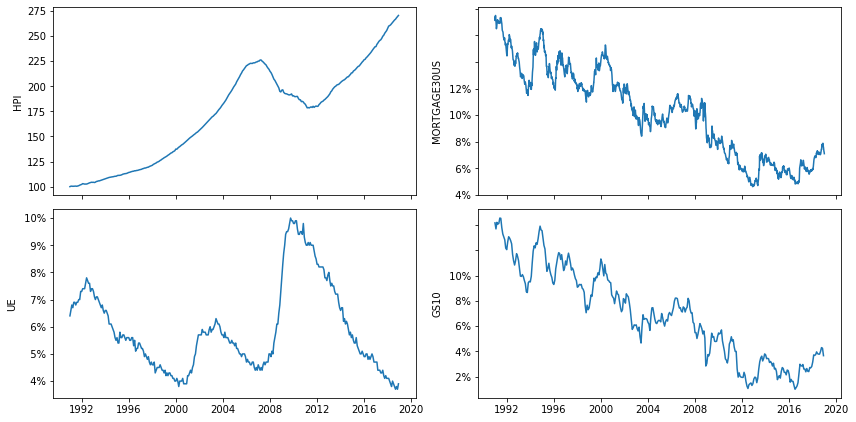

In [6]:
ncols = 2
nrows = -(-len(list_macrovars)//ncols)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(12, 6))
axes_list = [item for sublist in axes for item in sublist]

def trillions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fT' % (x * 1e-3)

for var in list_macrovars:
    ax = axes_list.pop(0)
    ax.plot(dict_macrovars[var]['df'])
    ax.set_ylabel(var)
    
    if var in ('UE','MORTGAGE30US','GS10'):
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])

    if var in ('GDP'):
        formatter = FuncFormatter(trillions)
        ax.yaxis.set_major_formatter(formatter)
        
plt.tight_layout()

# Discuss - KPSS v/s ADF Stationarity Null

In [7]:
partial_dict = [print(v) for i, v in enumerate(dict_macrovars.items()) if i < 2]

pprint.pprint(partial_dict)

('HPI', {'df':                HPI
Date              
1991-01-01  100.00
1991-02-01  100.44
1991-03-01  100.49
1991-04-01  100.33
1991-05-01  100.39
1991-06-01  100.52
1991-07-01  100.55
1991-08-01  100.37
1991-09-01  100.62
1991-10-01  100.93
1991-11-01  101.48
1991-12-01  101.84
1992-01-01  102.25
1992-02-01  102.98
1992-03-01  102.81
1992-04-01  102.54
1992-05-01  102.61
1992-06-01  102.58
1992-07-01  102.90
1992-08-01  103.38
1992-09-01  103.78
1992-10-01  104.07
1992-11-01  104.37
1992-12-01  104.27
1993-01-01  104.34
1993-02-01  104.10
1993-03-01  104.44
1993-04-01  105.11
1993-05-01  105.30
1993-06-01  105.70
...            ...
2016-07-01  232.50
2016-08-01  233.72
2016-09-01  235.25
2016-10-01  236.57
2016-11-01  237.95
2016-12-01  239.18
2017-01-01  239.37
2017-02-01  241.67
2017-03-01  242.88
2017-04-01  244.47
2017-05-01  245.52
2017-06-01  246.21
2017-07-01  247.66
2017-08-01  249.67
2017-09-01  250.74
2017-10-01  252.69
2017-11-01  254.06
2017-12-01  255.40
2018-01-01  257.

<hr style="height:2px;border:none;color:#333;background-color:#333;" />

Step above shows that HPI, GDP and Mortgage rates are non stationary; from literature we know log transform of macrovariables that represent levels are made stationary via a log difference transform, whereas a differencing works for absolute rates. Hence, for HPI and GDP variables and apply a log-difference and we difference the 30 Year Mortgage Rate time series and the unemployment rate where we observed conflicting results with the KPSS and ADF tests

In [8]:
for var in list_macrovars:
    if var in ('HPI','GDP'):
        df = np.log(dict_macrovars[var]['df']).diff().dropna()
        df = df.rename(columns={df.columns[0]: f'{var}_logDiff'})
        dict_macrovars[f'{var}_logDiff'] = {'df':df}
    elif var in ('MORTGAGE30US','UE','GS10'):
        df = (dict_macrovars[var]['df']).diff().dropna()
        df = df.rename(columns={df.columns[0]: f'{var}_Diff'})
        dict_macrovars[f'{var}_Diff'] = {'df':df}
    else:
        pass

We now check for stationarity of the transformed variables

In [9]:
partial_dict = [print(v) for i, v in enumerate(dict_macrovars.items()) if i < 2]

pprint.pprint(partial_dict)

('HPI', {'df':                HPI
Date              
1991-01-01  100.00
1991-02-01  100.44
1991-03-01  100.49
1991-04-01  100.33
1991-05-01  100.39
1991-06-01  100.52
1991-07-01  100.55
1991-08-01  100.37
1991-09-01  100.62
1991-10-01  100.93
1991-11-01  101.48
1991-12-01  101.84
1992-01-01  102.25
1992-02-01  102.98
1992-03-01  102.81
1992-04-01  102.54
1992-05-01  102.61
1992-06-01  102.58
1992-07-01  102.90
1992-08-01  103.38
1992-09-01  103.78
1992-10-01  104.07
1992-11-01  104.37
1992-12-01  104.27
1993-01-01  104.34
1993-02-01  104.10
1993-03-01  104.44
1993-04-01  105.11
1993-05-01  105.30
1993-06-01  105.70
...            ...
2016-07-01  232.50
2016-08-01  233.72
2016-09-01  235.25
2016-10-01  236.57
2016-11-01  237.95
2016-12-01  239.18
2017-01-01  239.37
2017-02-01  241.67
2017-03-01  242.88
2017-04-01  244.47
2017-05-01  245.52
2017-06-01  246.21
2017-07-01  247.66
2017-08-01  249.67
2017-09-01  250.74
2017-10-01  252.69
2017-11-01  254.06
2017-12-01  255.40
2018-01-01  257.

In [10]:
#stationary_vars = ['HPI_logDiff', 'GDP_logDiff', 'MORTGAGE30US_Diff','UE_Diff','GS10_Diff']
stationary_vars = ['HPI_logDiff', 'MORTGAGE30US_Diff','UE_Diff','GS10_Diff']
for var in stationary_vars:
    kpss_stats, adf_stats = stationarity_test(dict_macrovars[var]['df'].iloc[:,0],'5%',display=True)
    dict_macrovars[var] = {'df': dict_macrovars[var]['df'], 'kpss_stats':kpss_stats, 'adf_stats':adf_stats}

Var: HPI_logDiff KPSS:  Stationary ADF Stationary 0.148056252930996 2.3746097351270863
Var: MORTGAGE30US_Diff KPSS:  Stationary ADF Stationary 0.08739290205227969 14.073129137295355
Var: UE_Diff KPSS:  Stationary ADF Stationary 0.1181149250042529 3.6046280020483565
Var: GS10_Diff KPSS:  Stationary ADF Stationary 0.09341560845373294 8.986477573772767


Population of the dataframe with variables used in analysis
<br>
This for loop populates the dataframe from the dictionary dict_macrovars

In [11]:
df_all = pd.DataFrame(index=['Date'])#dataframe of MEVs is now constructed
df_all.dropna(inplace=True)

for mev_name, mev_dict in dict_macrovars.items():
    df = mev_dict['df'].copy()
    df_all = df_all.join(df, how='outer')
    #print(df.head(5))
    #print(df_all.head(5))

df_wide = df_all.dropna()
print(df_wide.head(5))

                        HPI  MORTGAGE30US   UE  GS10  HPI_logDiff  \
1991-02-01 00:00:00  100.44      9.560000  6.6  7.85     0.004390   
1991-03-01 00:00:00  100.49      9.400000  6.8  8.11     0.000498   
1991-04-01 00:00:00  100.33      9.507143  6.7  8.04    -0.001593   
1991-05-01 00:00:00  100.39      9.487143  6.9  8.07     0.000598   
1991-06-01 00:00:00  100.52      9.454286  6.9  8.28     0.001294   

                     MORTGAGE30US_Diff  UE_Diff  GS10_Diff  
1991-02-01 00:00:00          -0.007143      0.2      -0.24  
1991-03-01 00:00:00           0.015714      0.2       0.26  
1991-04-01 00:00:00          -0.004286     -0.1      -0.07  
1991-05-01 00:00:00          -0.008571      0.2       0.03  
1991-06-01 00:00:00           0.004286      0.0       0.21  


In [12]:
df_wide.head()

,HPI,MORTGAGE30US,UE,GS10,HPI_logDiff,MORTGAGE30US_Diff,UE_Diff,GS10_Diff
1991-02-01 00:00:00,100.44,9.560000,6.6,7.85,0.004390,-0.007143,0.2,-0.24
1991-03-01 00:00:00,100.49,9.400000,6.8,8.11,0.000498,0.015714,0.2,0.26
1991-04-01 00:00:00,100.33,9.507143,6.7,8.04,-0.001593,-0.004286,-0.1,-0.07
1991-05-01 00:00:00,100.39,9.487143,6.9,8.07,0.000598,-0.008571,0.2,0.03
1991-06-01 00:00:00,100.52,9.454286,6.9,8.28,0.001294,0.004286,0.0,0.21


In [13]:
for mev_name, mev_dict in dict_macrovars.items():
    print(mev_name)

HPI
MORTGAGE30US
UE
GS10
HPI_logDiff
MORTGAGE30US_Diff
UE_Diff
GS10_Diff


In [14]:
pprint.pprint(df_wide)

               HPI  MORTGAGE30US   UE  GS10  HPI_logDiff  MORTGAGE30US_Diff  \
1991-02-01  100.44      9.560000  6.6  7.85     0.004390          -0.007143   
1991-03-01  100.49      9.400000  6.8  8.11     0.000498           0.015714   
1991-04-01  100.33      9.507143  6.7  8.04    -0.001593          -0.004286   
1991-05-01  100.39      9.487143  6.9  8.07     0.000598          -0.008571   
1991-06-01  100.52      9.454286  6.9  8.28     0.001294           0.004286   
1991-07-01  100.55      9.648571  6.8  8.27     0.000298          -0.007143   
1991-08-01  100.37      9.448571  6.9  7.90    -0.001792          -0.008571   
1991-09-01  100.62      9.147143  6.9  7.65     0.002488          -0.001429   
1991-10-01  100.93      8.891429  7.0  7.53     0.003076          -0.007143   
1991-11-01  101.48      8.780000  7.0  7.42     0.005435          -0.018571   
1991-12-01  101.84      8.677143  7.3  7.09     0.003541          -0.011429   
1992-01-01  102.25      8.271429  7.3  7.03     0.00

<hr style="height:2px;border:none;color:#333;background-color:#333;" />

Pivot the a data frame above to create a wide dataframe


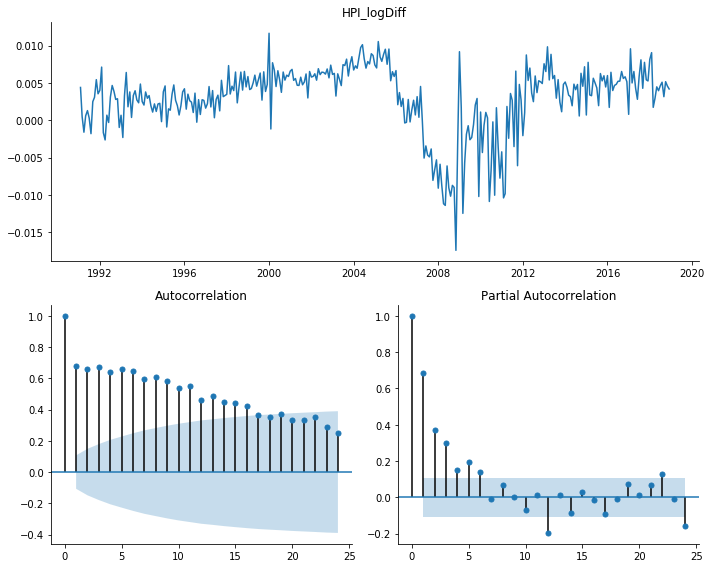

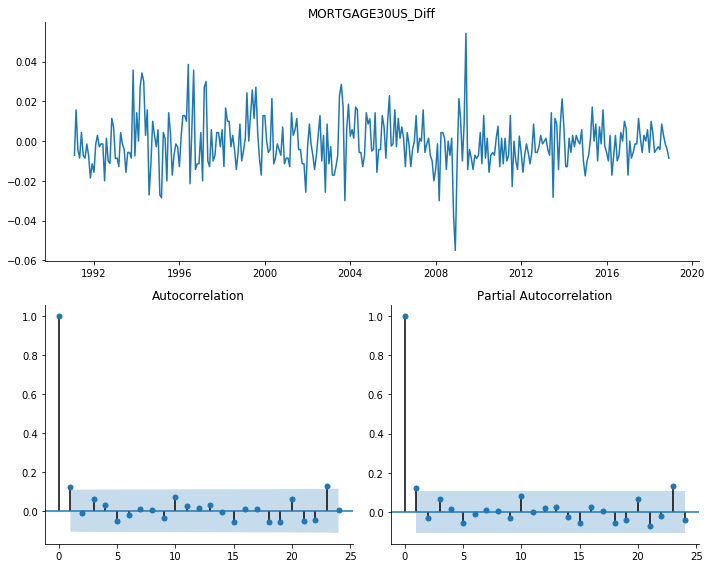

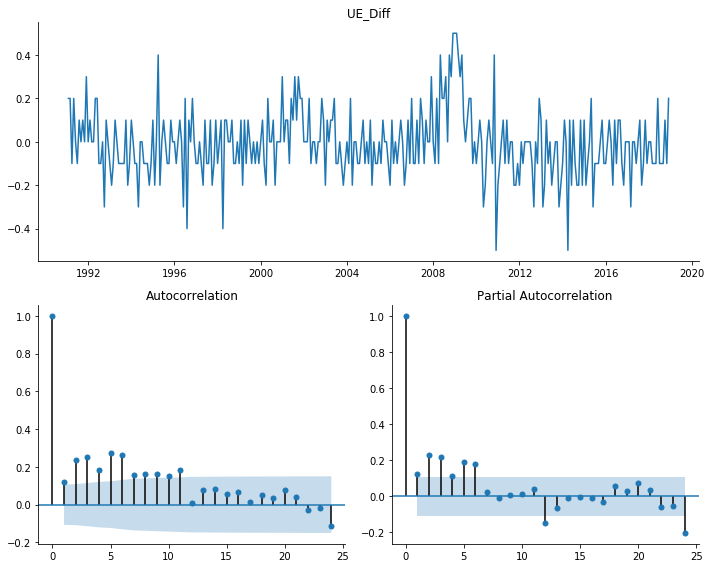

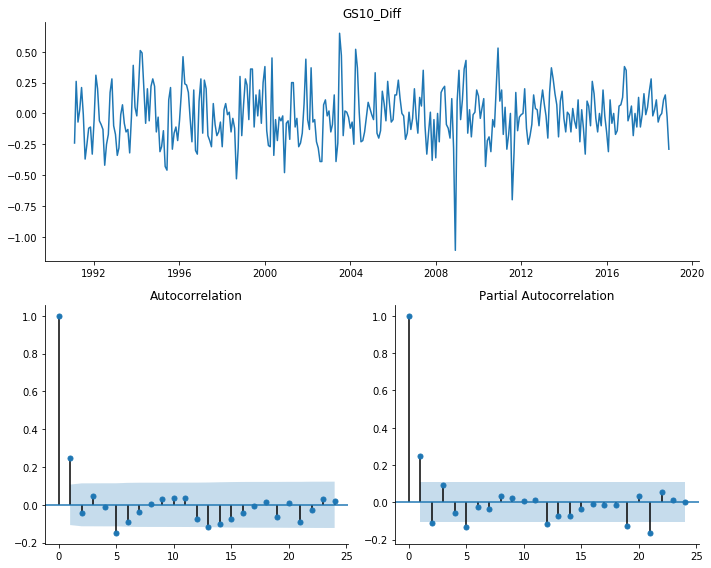

In [15]:
#This function plots the PAC, ACF
def tsplot(y, x, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    ts_ax.set_title(x)

    ts_ax.plot(y.index,y.values)
    #y.plot(ax=ts_ax)
    smodels.graphics.tsa.plot_acf(y, alpha = 0.05, use_vlines= True,lags=24, ax=acf_ax)
    smodels.graphics.tsa.plot_pacf(y, alpha = 0.05, use_vlines= True, lags=24, ax=pacf_ax)
    #[ax.set_xlim(0.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

#ACF,PACF plotting function is called in a loop run on all model variables 
for var in stationary_vars:
    tsplot(df_wide[var],var)

#plt.plot(df_wide['HPI_logDiff'].index,df_wide['HPI_logDiff'].values)

# Part A
<br>
<br>PACF Plots suggest a max lag of 12
<br>
<br>
We now construct the Vector Auto Regression models for the macro variables


In [16]:
varModelDF = df_wide[stationary_vars]#limit dataframe to only those stationary variables that will be use VAR model

#Run Model on test-train
list_vars = varModelDF.columns

lags = range(1, 5)
varModelDF = varModelDF.assign(**{
    '{}_{}'.format(col, t): varModelDF[col].shift(t)
    for t in lags
    for col in varModelDF
})

varModelDF.dropna(inplace=True) #VarModelDF will have lagged variables that have NaN - deleting those will start the time series from 1982

#test-train split etc.
startDate_train = datetime.strptime('1981-07-01', '%Y-%m-%d') #data start date parsed to required format
endDate_train = datetime.strptime('2012-07-01', '%Y-%m-%d')#train end date parsed to required format


dates_list = varModelDF.index #contains all dates

train_dates = [date for date in dates_list if (date >= startDate_train) & (date <= endDate_train)]

#all dates btwn start and end train are selected
test_dates = list(set(dates_list) - set(train_dates)) #dates selected from train are removed from total & alloc to test
test_dates.sort()

last_actual_data = (df_wide.loc[[endDate_train,]])#In order to transform the VAR model results back to levels, we need the last actuals

train_ModelDF = varModelDF.loc[train_dates]#form train dataframe using only train dates
test_ModelDF = varModelDF.loc[test_dates]#form test dataframe using only test dates


#var_model_list.append('UE')
#varModelDF = df_wide[var_model_list]
#varModelDF.dropna(inplace=True)

model = VAR(train_ModelDF[list_vars])

bic_results = model.fit(ic='bic',maxlags =12)


In [17]:
bic_results.summary() #for all variables, BIC ended up selecting L1 models


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Jul, 2019
Time:                     17:02:10
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -26.8002
Nobs:                     253.000    HQIC:                  -26.9671
Log likelihood:           2009.59    FPE:                1.73591e-12
AIC:                     -27.0795    Det(Omega_mle):     1.60521e-12
--------------------------------------------------------------------
Results for equation HPI_logDiff
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000668         0.000248            2.696           0.007
L1.HPI_logDiff               0.701091         0.045747           15.325           0.000
L1.MORTGAGE30US_Diff      

Based on BIC, the VAR model picks up only one lag. We want to benchmark this VAR Model with an OLS construct with a deeper lag structure; Hence we reran the VAR with maxlags = 4 to explore the relationshop. Given that the data is at quarterly frequency we do not see any reason for going beyond four lags for these macroeconomic variables.

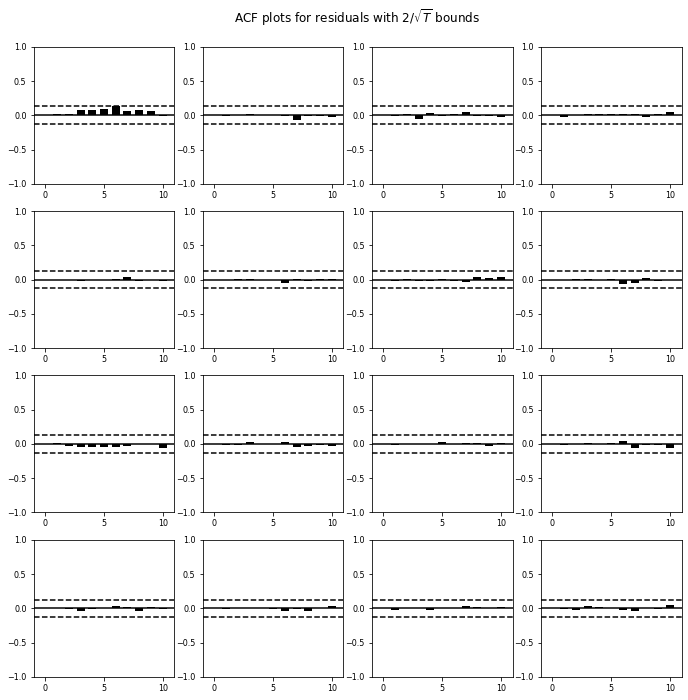

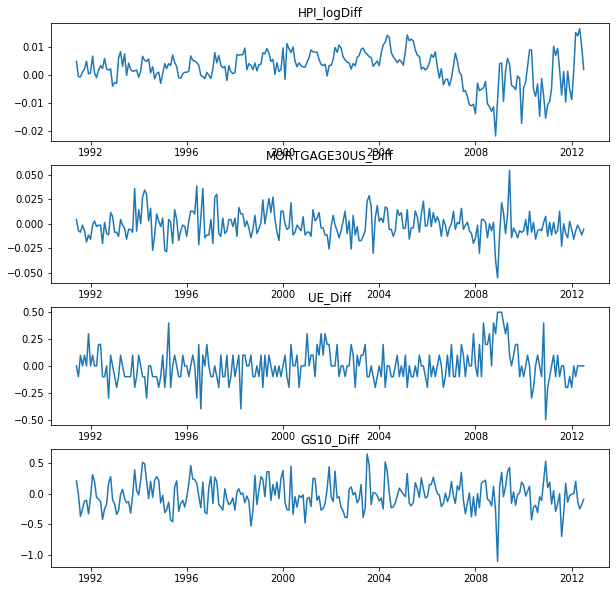

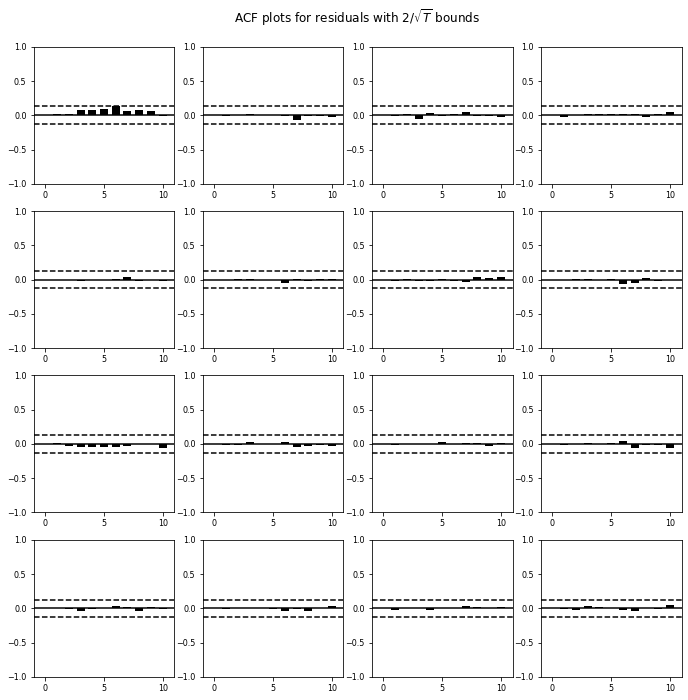

In [33]:
lag4_results = model.fit(maxlags =12)

lag4_results.plot()
lag4_results.plot_acorr()



In [35]:
lag4_results.summary() 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Jun, 2019
Time:                     17:41:25
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -23.7496
Nobs:                     242.000    HQIC:                  -25.4371
Log likelihood:           2038.09    FPE:                2.93980e-12
AIC:                     -26.5754    Det(Omega_mle):     1.40607e-12
--------------------------------------------------------------------
Results for equation HPI_logDiff
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.000095         0.000329           -0.288           0.773
L1.HPI_logDiff                0.471514         0.071792            6.568           0.000
L1.MORTGAGE30US_Diff  

# Part B

We now run the OLS regression based models

In [22]:
#OLS Models
ols_err = []

startDate_train = datetime.strptime('1981-07-01', '%Y-%m-%d') #data start date parsed to required format
endDate_train = datetime.strptime('2012-07-01', '%Y-%m-%d')#train end date parsed to required form

#HPI Model
#train_ModelDF = varModelDF.loc[sta]#form train dataframe using only train dates
#test_ModelDF = varModelDF.loc[test_dates]#form test dataframe using only test dates


var = ['HPI_logDiff_1','HPI_logDiff_2','HPI_logDiff_3']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['HPI_logDiff'], X)

hpiOLS = model.fit()
hpiOLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            HPI_logDiff   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     72.41
Date:                Fri, 28 Jun 2019   Prob (F-statistic):           1.24e-26
Time:                        10:41:49   Log-Likelihood:                 432.69
No. Observations:                 122   AIC:                            -857.4
Df Residuals:                     118   BIC:                            -846.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      1.138      0.257      -0.001       0.003
HPI_logDiff_1     0.6754      0.078      8.688      0.000       0.521       0.829
HPI_logDiff_2    -0.3391      0.093     -3.647      0.000      -0.523      -0.155
HPI_logDiff_3     0.5327      0.077      6.878      0.000       0.379       0.686
==============================================================================
Omnibus:                        1.380   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.502   Jarque-Bera (JB):                1.110
Skew:                          -0.232   Prob(JB):                        0.574
Kurtosis:                       3.061   Cond. No.                         178.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
#GDP Model
var = ['HPI_logDiff_1','GDP_logDiff_1','GDP_logDiff_2']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['GDP_logDiff'], X)

gdpOLS = model.fit()
gdpOLS.summary()




KeyError: "['GDP_logDiff_1', 'GDP_logDiff_2'] not in index"

In [24]:

#Mort Model
var = ['GS10_Diff']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['MORTGAGE30US_Diff'], X)

mortOLS = model.fit()
mortOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      MORTGAGE30US_Diff   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     33.74
Date:                Fri, 28 Jun 2019   Prob (F-statistic):           5.28e-08
Time:                        10:41:50   Log-Likelihood:                 376.94
No. Observations:                 122   AIC:                            -749.9
Df Residuals:                     120   BIC:                            -744.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.010      0.315      -0.003       0.001
GS10_Diff      0.0231      0.004      5.809      0.000       0.015       0.031
==============================================================================
Omnibus:                        3.565   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                4.008
Skew:                           0.074   Prob(JB):                        0.135
Kurtosis:                       3.876   Cond. No.                         3.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:


#UE Model
var = ['UE_Diff_1','GS10_Diff_1']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['UE_Diff'], X)

ueOLS = model.fit()
ueOLS.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                UE_Diff   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     15.85
Date:                Fri, 28 Jun 2019   Prob (F-statistic):           7.87e-07
Time:                        10:41:51   Log-Likelihood:                 53.041
No. Observations:                 122   AIC:                            -100.1
Df Residuals:                     119   BIC:                            -91.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0028      0.014     -0.195      0.846      -0.031       0.026
UE_Diff_1       0.4159      0.083      5.026      0.000       0.252       0.580
GS10_Diff_1     0.1888      0.055      3.425      0.001       0.080       0.298
==============================================================================
Omnibus:                        7.124   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                9.069
Skew:                          -0.316   Prob(JB):                       0.0107
Kurtosis:                       4.177   Cond. No.                         5.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
#Treasury Model
var = ['HPI_logDiff_3','HPI_logDiff_4']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['GS10_Diff'], X)

gs10OLS = model.fit()
gs10OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              GS10_Diff   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.119
Date:                Fri, 28 Jun 2019   Prob (F-statistic):              0.125
Time:                        10:41:51   Log-Likelihood:                -3.1683
No. Observations:                 122   AIC:                             12.34
Df Residuals:                     119   BIC:                             20.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0234      0.029     -0.796      0.427      -0.082       0.035
HPI_logDiff_3    -5.0770      2.759     -1.840      0.068     -10.541       0.387
HPI_logDiff_4     5.3690      2.751      1.952      0.053      -0.077      10.815
==============================================================================
Omnibus:                       33.838   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.923
Skew:                          -0.679   Prob(JB):                     1.17e-45
Kurtosis:                       9.234   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Part C

We will now try the Facebook Prophet algorithm

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0      107.272125
1      109.533915
2      111.422450
3      113.071037
4      114.280314
5      116.653206
6      119.214809
7      120.649549
8      121.524393
9      123.544155
10     124.087687
11     126.184228
12     128.522302
13     130.668156
14     131.885571
15     133.756659
16     135.532538
17     137.796130
18     139.686487
19     141.336896
20     142.547956
21     144.922651
22     147.486077
23     148.922640
24     149.799286
25     151.820845
26     152.366194
27     154.464552
28     156.531800
29     158.402022
          ...    
100    364.630371
101    362.213058
102    359.931816
103    356.523712
104    352.608351
105    349.837901
106    345.538584
107    342.792274
108    340.392777
109    337.746624
110    334.119373
111    331.145794
112    328.182325
113    325.653910
114    322.699600
115    319.505342
116    315.977054
117    313.559741
118    311.278499
119    307.870395
120    303.955034
121    301.184584
122    299.855309
123    296.240417
124    291

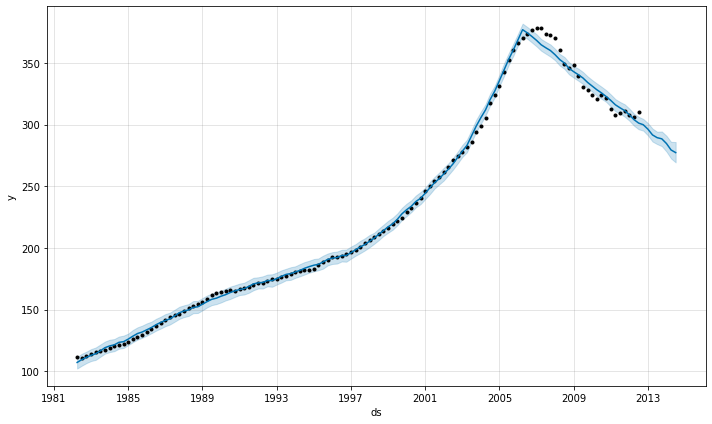

In [28]:
prophet = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
timeSeries = pd.DataFrame()
timeSeries['ds'] = df_wide.loc[train_dates].index
timeSeries['y'] = df_wide.loc[train_dates].HPI.values
prophet.fit(timeSeries)
future = prophet.make_future_dataframe(periods=8, freq='Q')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)

hpiFB = forecast['yhat']
hpiFB


# Forecast and transform back to original levels

Define Mean Absolute Error - the error metric we'll use for checking model errors.

In [29]:
#Define MAE
def mae(ypred, ytrue):
    """ returns the mean absolute percentage error """
    return np.mean(np.abs(ypred-ytrue))

In [30]:
#test performance
startDt = test_dates[0]
endDt = test_dates[-1]

#lag_order = results.k_ar
lag_order = 1
#Number of forecast periods - we will change this later
fcst_period = len(test_ModelDF)
#train_varModelDF.values[-lag_order:]
fcst_var = bic_results.forecast(train_ModelDF[list_vars].values[-lag_order:], fcst_period)

Given that the WSJ forecast is available for 2 years (8 periods and not 25 as shown in code above), forecast will be used in conjunction with WSJ forecast for the same timeframe. We test the MAE on a longer time period.

In [31]:
def to_levels(dataframe, last_vals):
    df = dataframe.copy()
    for col in df.columns:
        if('_Diff' in col):
            df[col] = np.cumsum(df[col]) + last_vals[col[:-5]][0]
        elif('_logDiff' in col):
            df[col] = np.exp(np.cumsum(df[col])) * last_vals[col[:-8]][0]
        else:
            raise KeyError
    return df

In [32]:
forecastVar = pd.DataFrame(fcst_var).copy()
forecastVar.columns = list_vars

varModelfcst = to_levels(forecastVar, last_actual_data)
varModelfcst.columns = list_macrovars

In [34]:
forecast_dates = pd.date_range(last_actual_data.index[0], periods=fcst_period+1, freq='1MS')[1:]
varModelfcst.index = forecast_dates
varModelfcst

,HPI,MORTGAGE30US,UE,GS10
2012-08-01,313.946002,3.641923,8.172267,1.519328
2012-09-01,317.231793,3.641142,8.148088,1.505415
2012-10-01,320.404128,3.640211,8.126340,1.489031
2012-11-01,323.499764,3.639172,8.106415,1.471588
2012-12-01,326.544286,3.638057,8.087980,1.453475
2013-01-01,329.556738,3.636885,8.070718,1.434870
2013-02-01,332.551424,3.635672,8.054355,1.415897
2013-03-01,335.539123,3.634427,8.038668,1.396647
2013-04-01,338.527984,3.633160,8.023487,1.377193
2013-05-01,341.524184,3.631875,8.008684,1.357585


In [35]:
maeVar = mae(varModelfcst, df_wide.loc[forecast_dates, list_macrovars])

In [37]:
var = ['HPI_logDiff_1','HPI_logDiff_2','HPI_logDiff_3']
X = smodels.add_constant(test_ModelDF[var])
olsfcstHPI  = pd.DataFrame(hpiOLS.predict(X))

#var = ['HPI_logDiff_1','GDP_logDiff_1','GDP_logDiff_2']
#X = smodels.add_constant(test_ModelDF[var])
#olsfcstGDP  = pd.DataFrame(gdpOLS.predict(X))

var = ['GS10_Diff']
X = smodels.add_constant(test_ModelDF[var])
olsfcstMort = pd.DataFrame(mortOLS.predict(X))

var = ['UE_Diff_1','GS10_Diff_1']
X = smodels.add_constant(test_ModelDF[var])
olsfcstUE   = pd.DataFrame(ueOLS.predict(X))

var = ['HPI_logDiff_3','HPI_logDiff_4']
X = smodels.add_constant(test_ModelDF[var])
olsfcstGS   = pd.DataFrame(gs10OLS.predict(X))


In [38]:
#forecastOLS = pd.concat([olsfcstHPI,olsfcstGDP,olsfcstMort,olsfcstUE,olsfcstGS],axis = 1)
forecastOLS = pd.concat([olsfcstHPI,olsfcstMort,olsfcstUE,olsfcstGS],axis = 1)
forecastOLS.columns = list_vars
olsModelfcst = to_levels(forecastOLS, last_actual_data)
olsModelfcst.columns = list_macrovars

In [39]:
olsModelfcst

,HPI,MORTGAGE30US,UE,GS10
2012-10-01,312.145301,3.642532,8.180199,1.583952
2013-01-01,312.088434,3.645905,8.183057,1.524637
2013-04-01,314.771869,3.640265,8.257716,1.413871
2013-07-01,319.189628,3.645717,8.258736,1.418682
2013-10-01,322.050078,3.640308,8.225617,1.412138
2014-01-01,325.146229,3.638365,8.186934,1.337837
2014-04-01,329.180181,3.637116,8.134984,1.318914
2014-07-01,334.206250,3.634711,7.922336,1.336502
2014-10-01,337.190043,3.628378,7.949790,1.313117
2015-01-01,341.173770,3.619734,7.820374,1.241105


In [40]:
maeOLS = mae(olsModelfcst.loc[forecast_dates], df_wide.loc[forecast_dates, list_macrovars])

In [41]:
print("MAE - Var and OLS models")
print(maeVar)
print(maeOLS)

MAE - Var and OLS models
HPI             26.741598
MORTGAGE30US     0.522721
UE               0.850362
GS10             1.054730
dtype: float64
HPI             4.707754
MORTGAGE30US    0.513822
UE              1.056197
GS10            0.922933
dtype: float64


# Plot the various model forecasts v/s actuals

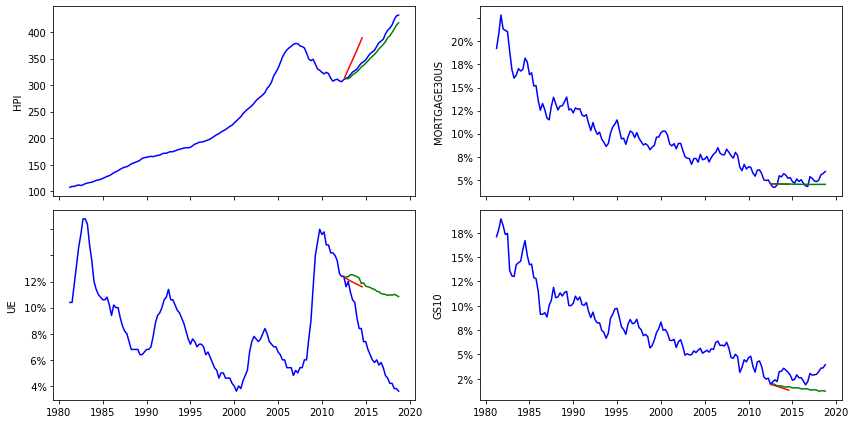

In [42]:
ncols = 2
nrows = -(-len(list_macrovars)//ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(12, 6))
axes_list = [item for sublist in axes for item in sublist]

for var in list_macrovars:
    ax = axes_list.pop(0)
    ax.plot(df_wide[var],color='blue')
    ax.plot(varModelfcst[var],color='red')
    ax.plot(olsModelfcst[var],color='green')
    ax.set_ylabel(var)
    
    if var in ('UE','MORTGAGE30US','GS10'):
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])

    if var in ('GDP'):
        formatter = FuncFormatter(trillions)
        ax.yaxis.set_major_formatter(formatter)
        
plt.tight_layout()

From the above it's clear we want to use OLS models; We will build out a rolling-period forecast. How this works is, essentially, we will use a training window, forcast out the next 8 quarters of the macro variable; move the training window out by one quarter and generate a new 8 period forecast

# Rolling Forecast

In [49]:
#test-train split etc.
startDate_train = datetime.strptime('1982-04-01', '%Y-%m-%d') #data start date parsed to required format
last_forecast_date = datetime.strptime('2018-10-01', '%Y-%m-%d') + relativedelta(months=-24)  #data start date parsed to required format; Here the rationale is to use in the second step weighting which is contingent on the 24 month period.
fcst_start = datetime.strptime('2011-07-01', '%Y-%m-%d')#This date corresponds to first WSJ 50 economist survey start date

olsModelfcsts = pd.DataFrame() 

while(fcst_start<=last_forecast_date):
    fcst_end = fcst_start + relativedelta(months=24)#8 Qtr forecast

    dates_list = varModelDF.index #contains all dates
    last_actual_data = (df_wide.loc[[fcst_start,]])#In order to transform the model results back to levels, we need the last actuals

    train_dates = [date for date in dates_list if (date >= startDate_train) & (date < fcst_start)]
    fcst_dates = [date for date in dates_list if (date >= fcst_start) & (date <= fcst_end)]

    train_ModelDF = varModelDF.loc[train_dates]#form train dataframe using only train dates
    fcst_ModelDF = varModelDF.loc[fcst_dates]#form test dataframe using only test dates

    #HPI
    var = ['HPI_logDiff_1','HPI_logDiff_2','HPI_logDiff_3']
    X = smodels.add_constant(train_ModelDF[var])
    y = train_ModelDF['HPI_logDiff']
    model = smodels.OLS(y, X)
    hpiOLS = model.fit()
    X = smodels.add_constant(fcst_ModelDF[var])
    olsfcstHPI  = pd.DataFrame(hpiOLS.predict(X))


    #GDP
    #var = ['HPI_logDiff_1','GDP_logDiff_1','GDP_logDiff_2']
    #X = smodels.add_constant(train_ModelDF[var])
    #y = train_ModelDF['GDP_logDiff']
    #model = smodels.OLS(y, X)
    #gdpOLS = model.fit()
    #X = smodels.add_constant(fcst_ModelDF[var])
    #olsfcstGDP  = pd.DataFrame(gdpOLS.predict(X))

    #UE
    var = ['UE_Diff_1','GS10_Diff_1']
    X = smodels.add_constant(train_ModelDF[var])
    y = train_ModelDF['UE_Diff']
    model = smodels.OLS(y, X)
    ueOLS = model.fit()
    X = smodels.add_constant(fcst_ModelDF[var])
    olsfcstUE  = pd.DataFrame(ueOLS.predict(X))

    #MORTGAGE RATE
    var = ['GS10_Diff']
    X = smodels.add_constant(train_ModelDF[var])
    y = train_ModelDF['MORTGAGE30US_Diff']
    model = smodels.OLS(y, X)
    mortOLS = model.fit()
    X = smodels.add_constant(fcst_ModelDF[var])
    olsfcstMort  = pd.DataFrame(mortOLS.predict(X))


    #Treasury
    var = ['HPI_logDiff_3','HPI_logDiff_4']
    X = smodels.add_constant(train_ModelDF[var])
    y = train_ModelDF['GS10_Diff']
    model = smodels.OLS(y, X)
    gsOLS = model.fit()
    X = smodels.add_constant(fcst_ModelDF[var])
    olsfcstGS  = pd.DataFrame(gsOLS.predict(X))

    #forecastOLS = pd.concat([olsfcstHPI,olsfcstGDP,olsfcstMort,olsfcstUE,olsfcstGS],axis = 1)
    forecastOLS = pd.concat([olsfcstHPI,olsfcstMort,olsfcstUE,olsfcstGS],axis = 1)
    forecastOLS.columns = list_vars
    olsModelfcst = to_levels(forecastOLS, last_actual_data)
    olsModelfcst.reset_index(inplace=True)
    olsModelfcst.columns = ['ForcastDt'] + list_macrovars
    olsModelfcst['ModelDt'] = fcst_start - relativedelta(months=3)
    cols = olsModelfcst.columns.to_list()
    cols = cols[-1:] + cols[:-1]
    olsModelfcst = olsModelfcst[cols]
    olsModelfcsts = olsModelfcsts.append(olsModelfcst)
    
    
    fcst_start = fcst_start + relativedelta(months=3)

olsModelfcsts.head(10)

KeyError: "None of [DatetimeIndex(['2011-08-01'], dtype='datetime64[ns]', freq=None)] are in the [index]"

In [50]:
varModelDF.index

Index([1982-04-01 00:00:00, 1982-07-01 00:00:00, 1982-10-01 00:00:00,
       1983-01-01 00:00:00, 1983-04-01 00:00:00, 1983-07-01 00:00:00,
       1983-10-01 00:00:00, 1984-01-01 00:00:00, 1984-04-01 00:00:00,
       1984-07-01 00:00:00,
       ...
       2016-07-01 00:00:00, 2016-10-01 00:00:00, 2017-01-01 00:00:00,
       2017-04-01 00:00:00, 2017-07-01 00:00:00, 2017-10-01 00:00:00,
       2018-01-01 00:00:00, 2018-04-01 00:00:00, 2018-07-01 00:00:00,
       2018-10-01 00:00:00],
      dtype='object', length=147)

In [41]:
df_wide[list_macrovars].to_excel('macroVarActuals.xlsx')